In [21]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
from graphing_functions import *
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

### File Inputs

In [22]:
# Choose between 'mtDNA' and 'TFAM'
keyword = "mtDNA"

# for aggtype, choose between "mean" and "median".
# NOTE: Cell ROIs are always aggregated by median due to skewed distributions \
# This only changes how centrality is calculated for biological replicates
aggtype = "mean"

# for p-eval, choose between "roi", "cell", and "rep"
p_eval = "rep"
plot_rois = False
legend = False

In [23]:
table = pd.read_csv(f"/Volumes/Shares/SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/{keyword}/roi_data.csv")
outputpath = "/Volumes/Shares/SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/split_phase"
# table = pd.read_csv(f"Z://SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/{keyword}/roi_data.csv")
# outputpath = "Z://SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/split_phase"
table.head()

,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity
0,221114_mtDNA_aged_i23,punctate,0.095,39.042,5,96,1.000,3.690,41,937.0,1.091,0.916,0.980
1,221114_mtDNA_aged_i23,punctate,0.098,36.960,3,94,1.000,3.639,33,924.0,1.312,0.762,0.926
2,221114_mtDNA_aged_i23,punctate,0.185,87.340,9,255,0.966,16.167,56,4105.0,1.338,0.747,0.931
3,221114_mtDNA_aged_i23,punctate,0.067,22.294,10,37,1.000,1.493,21,379.0,1.192,0.839,0.919
4,221114_mtDNA_aged_i23,punctate,0.067,27.059,12,47,1.000,1.812,25,460.0,1.263,0.792,0.919


In [24]:
table_edits = table
table_edits['Group'] = table['Source'].str.split("_").str[2]
table_edits['Date'] = table['Source'].str.split('_').str[0]
print(f"Table shape {table_edits.shape}")
table_edits.head()

Table shape (24185, 15)


,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity,Group,Date
0,221114_mtDNA_aged_i23,punctate,0.095,39.042,5,96,1.000,3.690,41,937.0,1.091,0.916,0.980,aged,221114
1,221114_mtDNA_aged_i23,punctate,0.098,36.960,3,94,1.000,3.639,33,924.0,1.312,0.762,0.926,aged,221114
2,221114_mtDNA_aged_i23,punctate,0.185,87.340,9,255,0.966,16.167,56,4105.0,1.338,0.747,0.931,aged,221114
3,221114_mtDNA_aged_i23,punctate,0.067,22.294,10,37,1.000,1.493,21,379.0,1.192,0.839,0.919,aged,221114
4,221114_mtDNA_aged_i23,punctate,0.067,27.059,12,47,1.000,1.812,25,460.0,1.263,0.792,0.919,aged,221114


### Removal of Outliers

1. Removal of cells with visually defective AI predictions from the dataset

In [25]:
poor_predictions = {
    # 64 mtDNA images - 5 = 59 images left
    'mtDNA': ['221207_mtDNA_young_i3', '230727_mtDNA_young_i3', 
              '230731_mtDNA_aged_i14l', '230731_mtDNA_aged_14u', 
              '230731_mtDNA_aged_i18'],
    # 30 TFAM images - 2 images = 28 images left
    'TFAM': ['230210_TFAM_aged_i26', '230210_TFAM_aged_i25']
}

before_count = table_edits.shape[0]
print(f"{before_count} rois before cell removal")
for cell in poor_predictions[keyword]:
    table_edits = table_edits[table_edits['Source'] != cell]
print(f"{table_edits.shape[0]} rois after removal")
print(f"{before_count - table_edits.shape[0]} rois removed")

24185 rois before cell removal
21873 rois after removal
2312 rois removed


2. Removal of outliers by:
    1. separating dataset into puncate and diffuse subsets
    2. removing outliers from each subset using 1.5 times IQR
    3. re-combining punctate and diffuse datasets for further manipulation / graphing

In [26]:
#2.1 - separating dataset into punctate and diffuse subsets
punctate_table = table_edits[table_edits['RoiType'] == 'punctate']
diffuse_table = table_edits[table_edits['RoiType'] == 'diffuse']
assert punctate_table.shape[0] + diffuse_table.shape[0] == table_edits.shape[0]

Checking distribution for punctate roi ara before outlier removal

<Axes: xlabel='Area', ylabel='Density'>

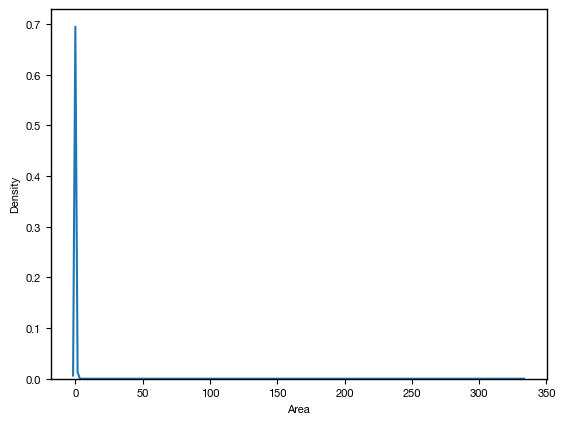

In [27]:
sns.kdeplot(data=punctate_table['Area'])

In [28]:
#2.2 - removal of rois for each dataset using z-score
punctate_no_outliers = iqr_removal(punctate_table)
po = punctate_no_outliers.isna().sum()

diffuse_no_outliers = iqr_removal(diffuse_table)
do = diffuse_no_outliers.isna().sum()

summary = pd.concat([po, round(po / punctate_table.shape[0] * 100, 2), 
                     do, round(do / diffuse_table.shape[0] * 100, 2)], axis = 1)
summary.columns = ['p-outlier#', 'p-outlier%', 'd-outlier#', 'd-outlier%']
summary


,p-outlier#,p-outlier%,d-outlier#,d-outlier%
Source,0,0.00,0,0.00
RoiType,0,0.00,0,0.00
Area,1832,10.55,686,15.21
Mean,1401,8.07,448,9.93
Min,569,3.28,180,3.99
Max,1496,8.62,339,7.51
Circ.,2415,13.91,1,0.02
IntDen,1917,11.04,688,15.25
Median,1508,8.69,573,12.70
RawIntDen,1923,11.08,690,15.30


Checking distribution for punctate ROI after outlier removal

<Axes: xlabel='Area', ylabel='Density'>

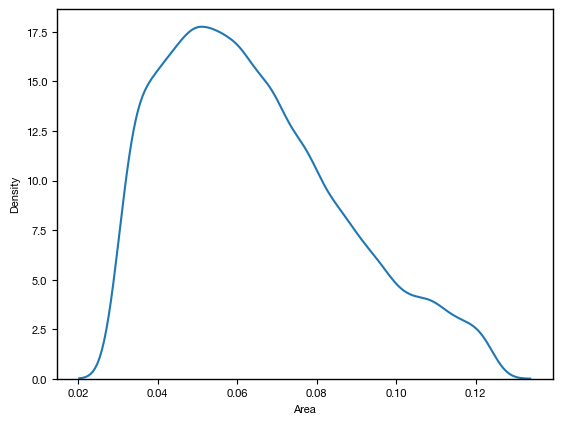

In [29]:
sns.kdeplot(data=punctate_no_outliers["Area"])

In [30]:
#3.3 re-combine dataset for further analysis
no_outlier = pd.concat([punctate_no_outliers, diffuse_no_outliers], axis = 0)
# no_outlier = no_outlier[["Source", "Date", "Group", "RoiType", "Area", "Mean", "Min", "Max",
#                             "Circ.", "IntDen", "Median", "RawIntDen", "AR", "Round", "Solidity"]].dropna()
no_outlier = no_outlier[["Source", "Date", "Group", "RoiType", "Area", "Mean", "Circ."]].dropna()

In [31]:
print(no_outlier.shape)
no_outlier.to_csv(os.path.join(outputpath, f"{keyword}_ROIs_splitPhase_noOutlier.csv"))

(16656, 7)


### Grouping and Aggregating Data

First by at the level of an individual cell

In [32]:
cell_dict = {}
for header in no_outlier.columns:
    if header == "Source" or header == "RoiType" or header == "Group":
        continue
    elif header == "Date":
        cell_dict[header] = "first"
    else:
        cell_dict[header] = "median"

cell_means = no_outlier.groupby(["Source","RoiType","Group"]).agg(cell_dict)
cell_means = cell_means.reset_index()
cell_means.head()

,Source,RoiType,Group,Date,Area,Mean,Circ.
0,221114_mtDNA_aged_i23,diffuse,aged,221114,0.0530,27.891,0.8960
1,221114_mtDNA_aged_i23,punctate,aged,221114,0.0750,34.750,1.0000
2,221114_mtDNA_aged_i25,diffuse,aged,221114,0.0550,33.343,0.7370
3,221114_mtDNA_aged_i25,punctate,aged,221114,0.0845,33.971,0.9295
4,221114_mtDNA_aged_i8,diffuse,aged,221114,0.0430,39.900,0.8110


In [33]:
print(cell_means.shape)
cell_means.to_csv(os.path.join(outputpath, f"{keyword}_splitPhase_cellMeans.csv"))

(114, 7)


Then at the level of a biological replicate

In [34]:
rep_dict = {}
# for header in no_outlier.columns:
for header in cell_means.columns:
    if header == "Date" or header == "RoiType" or header == "Group":
        continue
    elif header == "Source":
        rep_dict[header] = "first"
    else:
        rep_dict[header] = aggtype

rep_means = cell_means.groupby(["Date", "RoiType","Group"]).agg(rep_dict)
rep_means = rep_means.reset_index()
rep_means.head()

,Date,RoiType,Group,Source,Area,Mean,Circ.
0,221114,diffuse,aged,221114_mtDNA_aged_i23,0.050333,33.711333,0.814667
1,221114,diffuse,young,221114_mtDNA_young_i18,0.050250,31.708375,0.819125
2,221114,punctate,aged,221114_mtDNA_aged_i23,0.079167,35.573667,0.964833
3,221114,punctate,young,221114_mtDNA_young_i18,0.087000,33.917875,0.986500
4,221207,diffuse,aged,221207_mtDNA_aged_i11,0.048091,32.760727,0.705500


In [35]:
print(rep_means.shape)
rep_means.to_csv(os.path.join(outputpath, f"{keyword}_splitPhase_repMeans.csv"))

(18, 7)


### Splitting Aggregated Groups into punctate and diffuse dataframes

In [36]:
punctate_table = no_outlier[no_outlier["RoiType"] == 'punctate']
punctate_means = cell_means[cell_means["RoiType"] == 'punctate']
punctate_reps = rep_means[rep_means["RoiType"] == 'punctate']

diffuse_table = no_outlier[no_outlier["RoiType"] == 'diffuse']
diffuse_means = cell_means[cell_means["RoiType"] == 'diffuse']
diffuse_reps = rep_means[rep_means["RoiType"] == 'diffuse']

### Computing p-values to be graphed

In [37]:
rep_pvalues = {}
if p_eval == 'roi':
   pdict = punctate_table
   ddict = diffuse_table
elif p_eval == 'cell':
   pdict = punctate_means
   ddict = diffuse_means
elif p_eval == 'rep':
   pdict = punctate_reps
   ddict = diffuse_reps
else:
   raise ValueError(f"p_eval value '{p_eval}' not recognized. Please choose between 'roi', 'cell', and 'rep'")

for key, value in rep_dict.items():
    if value == "first":
      continue 
    pYoung = pdict[pdict["Group"] == 'young'][key]
    pAged = pdict[pdict["Group"] == 'aged'][key]
    if key == "Area":
      print(pYoung.isna().count())

    pP = stats.mannwhitneyu(pYoung, pAged)[1]

    dYoung = ddict[ddict["Group"] == 'young'][key]
    dAged = ddict[ddict["Group"] == 'aged'][key]
    dP = stats.mannwhitneyu(dYoung, dAged)[1]

    pP, dP = round(pP, 10), round(dP, 10)
    rep_pvalues[key] = (pP, dP)

5


In [38]:
rep_pvalues

{'Area': (0.4126984127, 0.0317460317),
 'Mean': (0.7301587302, 0.2857142857),
 'Circ.': (0.1111111111, 0.7301587302)}

### Plotting data and saving plots to output directory

In [39]:
def plot_y(punctate_dfs, diffuse_dfs, pDict, yMetric, outpath, log=False):    
    hue_order = sorted(table_edits['Date'].unique()[::-1])
    figdims = (2.32, 2)
    fig = plt.figure(figsize=figdims)

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    punctate_table, punctate_means, punctate_reps = punctate_dfs[0], punctate_dfs[1], punctate_dfs[2]
    diffuse_table, diffuse_means, diffuse_reps = diffuse_dfs[0], diffuse_dfs[1], diffuse_dfs[2]

    the_p_table = punctate_table if plot_rois else punctate_means 
    the_d_table = diffuse_table if plot_rois else diffuse_means 
    tempymin = min(the_p_table[yMetric].min(), the_d_table[yMetric].min())
    tempymin = tempymin if tempymin < 0 else 0
    tempymax = max(the_p_table[yMetric].max(), the_d_table[yMetric].max())

    gOrder = ["young", "aged"]

    # Plotting points...
    if plot_rois:
        sns.stripplot(data=punctate_table, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, jitter=0.3, alpha=0.33, size=0.5, ax=ax1, legend=False, zorder=0)
        sns.stripplot(data=diffuse_table, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, jitter=0.3, alpha=0.33, size=0.5, ax=ax2, legend=False, zorder=0)

    sns.swarmplot(data=punctate_means, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=1, linewidth=0.3, edgecolor='k', ax=ax1, legend=False, zorder = 1)
    sns.swarmplot(data=diffuse_means, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=1, linewidth=0.3, edgecolor='k', ax=ax2, legend=False, zorder=1)

    plot_sem(ax1, 0, 0.15, punctate_means, yMetric, 'young')
    plot_sem(ax1, 1, 0.15, punctate_means, yMetric, 'aged')
    plot_sem(ax2, 0, 0.15, diffuse_means, yMetric, 'young')
    plot_sem(ax2, 1, 0.15, diffuse_means, yMetric, 'aged')

    sns.swarmplot(data=punctate_reps, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=2.5, linewidth=0.55, edgecolor='k', ax=ax1, legend=False, zorder = 2)
    sns.swarmplot(data=diffuse_reps, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=2.5, linewidth=0.55, edgecolor='k', ax=ax2, legend=False, zorder = 2)

    # Y-Axis formatting
    if tempymax < 1:
        ymax = tempymax * 1.1
    elif tempymax > 1:
        ymax = tempymax * 1.1
    else:
        ymax = 1.1
    ax1.set_ylim((tempymin / 1.2, ymax))
    ax1.yaxis.set_tick_params(width=0.5, pad=0.35)
    ax1.xaxis.set_tick_params(width=0.5, pad=0.5)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.set_tick_params(width=0.5, pad=0.35)
    ax2.xaxis.set_tick_params(width=0.5, pad=0.5)
    ax2.tick_params(labelleft=False)

    # X-Axis formatting
    ax1.set_xlim(left=-0.5, right=1.5)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(["P30\ndays", "P24\nmonths"])
    
    ax2.set_xlim(left=-0.5, right=1.5)
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(["P30\ndays", "P24\nmonths"])

    #Axis labels
    ax1.set_xlabel("")
    ax1.set_ylabel(process_title(yMetric, keyword))
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    # ax2.legend(hue_order, title="Rep")

    # Axis titles
    # ax1.set_title("Punctate", weight = 'bold')
    # ax2.set_title("Diffuse", weight = 'bold')

    # Legend formatting
    if legend:
        markers = [Line2D(range(1), range(1), linewidth=0, marker='o', markersize=1, markerfacecolor='#e4e4e4', markeredgecolor="k", markeredgewidth=0.3),
                Line2D(range(1), range(1), linewidth=0, marker='o', markersize=2.5, markerfacecolor='#e4e4e4', markeredgecolor="k", markeredgewidth=0.55),]
        marker_labels = ["Single Cell All-ROI Mean", 
                        "Single Rep All-ROI Mean"]
        markers.insert(0, Line2D(range(1), range(1), linewidth=0, marker='o', markersize=0.5, markerfacecolor='#e4e4e4', markeredgecolor="k", markeredgewidth=0.1)) if plot_rois else '' 
        marker_labels.insert(0, "Individual ROI") if plot_rois else ''
        lgnd = ax2.legend(markers, marker_labels)
        bbox_dims = (0.5, -0.4) 
        sns.move_legend(ax2, "lower center", bbox_to_anchor = bbox_dims)

    # Graphing p-values
    ymax2 = tempymax * 1.05
    ax1.plot([0, 1], [ymax2, ymax2], c = 'k', linewidth = 0.5)
    ax2.plot([0, 1], [ymax2, ymax2], c = 'k', linewidth = 0.5)
    pP, dP = pDict[yMetric][0], pDict[yMetric][1]

    ax1.text(0.5, ymax2, f"{format_p(pP)}", ha="center", va="bottom", c='k', weight = 'bold')
    ax2.text(0.5, ymax2, f"{format_p(dP)}", ha="center", va="bottom", c='k', weight = 'bold')

    # Final figure formatting
    ax1.spines[['right', 'top']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)

    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(os.path.join(outpath, f"{keyword}_{'all' if plot_rois else ''}ROI-{yMetric}_{aggtype}Agg_{p_eval}Stat.png"), dpi = 1800)
    plt.close()

In [40]:
# plt.style.use("ggplot")
# plt.rcParams['axes.facecolor']='#e4e4e4'
plt.rc('font', family="Helvetica Neue", size=8)
plt.rcParams['axes.linewidth'] = 1

pDfs = (punctate_table, punctate_means, punctate_reps)
dDfs = (diffuse_table, diffuse_means, diffuse_reps)

for key, value in rep_dict.items():
   if value == "first":
       continue 
   #this_log = True if key in ["Area", "Median", "Min", "Solidity", "IntDen"] else False
   plot_y(pDfs, dDfs, rep_pvalues, key, outputpath, log=True)